## Student Information
Name: 簡榮信

Student ID: 113034611

GitHub ID: LukaChien

Kaggle name: 113034611

Kaggle private scoreboard snapshot:

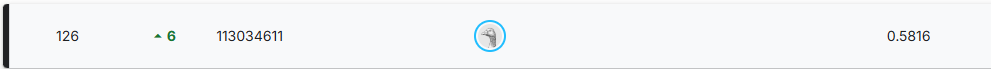


# (1) Preprocessing Steps
- (a) 讀取四個檔案
- (b) **解析 final_posts.json 並且取出 id / text 內容**
- (c) 解析 train / test 資料集以及情緒標籤
- (d) 合併 data_identification 與 emotion（只有 train 含有此標籤內容）
- (e) 清理資料集
- (f) 準備 train_df / test_df 兩個資料表
---

In [ ]:
# Config & Imports
import os, json, re, string, unicodedata, random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# 固定隨機種子數值
SEED = 42
random.seed(SEED); np.random.seed(SEED)

DATA_DIR = "."   # 檔案放同在同一個資料夾

ID_PATH   = os.path.join(DATA_DIR, "data_identification.csv")
EMO_PATH  = os.path.join(DATA_DIR, "emotion.csv")
POST_PATH = os.path.join(DATA_DIR, "final_posts.json")
SAMPLE_SUB_PATH = os.path.join(DATA_DIR, "samplesubmission.csv")

In [ ]:
# 讀檔解析：final_posts.json 轉 DataFrame（id, text)
def load_posts(json_path):
    rows = []
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    for item in data:
        try:
            post = item["root"]["_source"]["post"]
            rows.append({"id": post["post_id"], "text": post["text"]})
        except KeyError:
            continue
    return pd.DataFrame(rows)

df_posts = load_posts(POST_PATH)
print(df_posts.head(3))
print(df_posts.shape)

         id                                               text
0  0x61fc95  We got the ranch, loaded our guns and sat up t...
1  0x35663e  I bet there is an army of married couples who ...
2  0xc78afe                         This could only end badly.
(64171, 2)


In [ ]:
# 讀檔：train/test split 與情緒標籤
df_id  = pd.read_csv(ID_PATH)          # 抓 id, split
df_lab = pd.read_csv(EMO_PATH)         # 抓 id, emotion
df_ss  = pd.read_csv(SAMPLE_SUB_PATH)  # 參考一樣的格式：id, emotion

# 合併
df = df_posts.merge(df_id, on="id", how="left")
df = df.merge(df_lab, on="id", how="left")   # train 會有 emotion，test emotion 欄位則為 NaN 值
print(df.head(3))
df["split"].value_counts(dropna=False)

         id                                               text  split emotion
0  0x61fc95  We got the ranch, loaded our guns and sat up t...   test     NaN
1  0x35663e  I bet there is an army of married couples who ...  train     joy
2  0xc78afe                         This could only end badly.  train    fear


split
train    47890
test     16281
Name: count, dtype: int64

In [ ]:
# 資料清理
# 嘗試使用跟 Lab2 相同方式
URL_RE      = re.compile(r"http[s]?://\S+|www\.\S+")
MENTION_RE  = re.compile(r"@\w+")
HASHTAG_RE  = re.compile(r"#(\w+)")
EMOJI_RE    = re.compile(r"[\U00010000-\U0010ffff]", flags=re.UNICODE)

def normalize_text(s: str) -> str:
    s = s or ""
    s = unicodedata.normalize("NFKC", s)
    s = s.lower()
    s = URL_RE.sub(" ", s)
    s = MENTION_RE.sub(" ", s)
    # hashtag 保留詞根：#Love -> love
    s = HASHTAG_RE.sub(lambda m: " " + m.group(1).lower() + " ", s)
    s = EMOJI_RE.sub(" ", s)
    s = s.replace("&amp;", " and ")
    # 保留 !? 作為情緒線索，其餘標點則轉為空白
    keep = set("!?")
    s = "".join(ch if (ch not in string.punctuation or ch in keep) else " " for ch in s)
    # 重複空白並壓縮距離
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text_clean"] = df["text"].astype(str).apply(normalize_text)
df.loc[df["text_clean"].str.len() == 0, "text_clean"] = "(empty)"
print(df[["id","split","emotion","text_clean"]].head())


         id  split emotion                                         text_clean
0  0x61fc95   test     NaN  we got the ranch loaded our guns and sat up ti...
1  0x35663e  train     joy  i bet there is an army of married couples who ...
2  0xc78afe  train    fear                          this could only end badly
3  0x90089c  train     joy  my sister squeezed a lime in her milk when she...
4  0xaba820   test     NaN          and that got my head bobbing a little bit


In [ ]:
# 產出 train / test DataFrame
train_df = df[df["split"]=="train"].reset_index(drop=True)
test_df  = df[df["split"]=="test"].reset_index(drop=True)

print(train_df.shape, test_df.shape)
train_df["emotion"].value_counts()


(47890, 5) (16281, 5)


emotion
joy         23797
anger       10694
surprise     6281
sadness      3926
fear         2009
disgust      1183
Name: count, dtype: int64

# (2) Feature Engineering Steps
- baseline：使用 **TF-IDF**（word 1–2gram + char 3–5gram）對文字向量化 -> 以便支援 **Linear SVM** / Logistic Regression 的清理規則。
---

In [ ]:
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# 定義 TF-IDF 向量器（詞 + 字元)
tfidf_word = TfidfVectorizer(
    analyzer="word", ngram_range=(1,2),
    min_df=2, max_df=0.95, max_features=100_000,
    sublinear_tf=True
)
tfidf_char = TfidfVectorizer(
    analyzer="char", ngram_range=(3,5),
    min_df=2, max_df=0.95, max_features=100_000,
    sublinear_tf=True
)

Xw = tfidf_word.fit_transform(train_df["text_clean"])
Xc = tfidf_char.fit_transform(train_df["text_clean"])
X_train_tfidf = hstack([Xw, Xc]).tocsr()

# 使用簡單的 hand-crafted features：以長度、驚嘆號/問號數來看
def simple_feats(s: str):
    s = s or ""
    return [len(s), s.count("!"), s.count("?")]
H_train = np.vstack(train_df["text_clean"].apply(simple_feats).values)
H_train = csr_matrix(H_train)

X_train = hstack([X_train_tfidf, H_train]).tocsr()
y_train = train_df["emotion"].values

# test 使用與 train 相同的轉換
Xw_te = tfidf_word.transform(test_df["text_clean"])
Xc_te = tfidf_char.transform(test_df["text_clean"])
H_test = csr_matrix(np.vstack(test_df["text_clean"].apply(simple_feats).values))
X_test = hstack([Xw_te, Xc_te, H_test]).tocsr()


In [ ]:
# 建立驗證集（Stratified split）
tr_text, va_text, tr_y, va_y = train_test_split(
    train_df["text_clean"], y_train, test_size=0.15, random_state=SEED, stratify=y_train
)

Xw_tr = tfidf_word.transform(tr_text); Xc_tr = tfidf_char.transform(tr_text)
Hw_tr = csr_matrix(np.vstack(tr_text.apply(simple_feats).values))
X_tr = hstack([Xw_tr, Xc_tr, Hw_tr]).tocsr()

Xw_va = tfidf_word.transform(va_text); Xc_va = tfidf_char.transform(va_text)
Hw_va = csr_matrix(np.vstack(va_text.apply(simple_feats).values))
X_va = hstack([Xw_va, Xc_va, Hw_va]).tocsr()


# (3) Model Implementation Steps
- 目標：
    - (a) 建立 Pipeline: Cleaner -> TFIDF -> 分類器
    - (b) 用 Stratified split 做驗證
    - (c) 訓練 + 評估
    - (d) 對 test 預測並輸出 submission_baseline.csv
    ---

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# LinearSVC（文本分類常用）
# 用 CalibratedClassifierCV 取得可預測的機率
svm = LinearSVC(C=2.0, random_state=SEED)
clf = CalibratedClassifierCV(svm, cv=3)  

clf.fit(X_tr, tr_y)
va_pred = clf.predict(X_va)

print("Validation Macro F1 =", f1_score(va_y, va_pred, average="macro"))
print(classification_report(va_y, va_pred))


c:\Users\King\anaconda3\envs\Kenny\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\King\anaconda3\envs\Kenny\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\King\anaconda3\envs\Kenny\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\King\anaconda3\envs\Kenny\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\King\anaconda3\envs\Kenny\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True

Validation Macro F1 = 0.39977388865379143
              precision    recall  f1-score   support

       anger       0.58      0.41      0.48      1604
     disgust       0.53      0.06      0.10       178
        fear       0.56      0.26      0.35       301
         joy       0.63      0.91      0.75      3570
     sadness       0.60      0.17      0.26       589
    surprise       0.60      0.36      0.45       942

    accuracy                           0.62      7184
   macro avg       0.58      0.36      0.40      7184
weighted avg       0.61      0.62      0.58      7184



In [ ]:
# 用所有訓練資料重新訓練並再次預測 test
clf.fit(X_train, y_train)
test_pred = clf.predict(X_test)

# 生成提交檔
sub = test_df[["id"]].copy()
sub["emotion"] = test_pred
print(sub.head())

OUT_PATH = "submission_baseline.csv"
sub.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH, "shape:", sub.shape)


c:\Users\King\anaconda3\envs\Kenny\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\King\anaconda3\envs\Kenny\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\King\anaconda3\envs\Kenny\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\King\anaconda3\envs\Kenny\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\King\anaconda3\envs\Kenny\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True

         id emotion
0  0x61fc95     joy
1  0xaba820     joy
2  0x66e44d     joy
3  0xc03cf5     joy
4  0x02f65a   anger
Saved: submission_baseline.csv shape: (16281, 2)


c:\Users\King\anaconda3\envs\Kenny\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# (4) 額外 Section：2D / 3D UMAP 視覺化
---

In [ ]:
"""  
# 把 train/test 合併後，一起做降維後的可視化
from umap import UMAP
import plotly.express as px
from scipy.sparse import vstack

X_all = vstack([X_train, X_test])
all_df = pd.concat([train_df.assign(split_tag="train"), test_df.assign(split_tag="test")],
                   ignore_index=True)

# 2D
umap2 = UMAP(n_components=2, metric="cosine", random_state=SEED, n_neighbors=15, min_dist=0.1)
emb2d = umap2.fit_transform(X_all)

plot2d = pd.DataFrame(emb2d, columns=["UMAP1","UMAP2"])
plot2d["split"]   = all_df["split_tag"].values
plot2d["emotion"] = all_df["emotion"].fillna("(test)").values
plot2d["text"]    = all_df["text_clean"].values

fig2d = px.scatter(
    plot2d, x="UMAP1", y="UMAP2",
    color="emotion",
    symbol="split",  # train/test 用不同 marker
    hover_data={"text": True, "split": True, "emotion": True},
    title="2D UMAP Projection of TF-IDF Features"
)
fig2d.show()
"""

'\n# 把 train/test 合併後，一起做降維可視化（只有 train 有標籤）\nfrom umap import UMAP\nimport plotly.express as px\nfrom scipy.sparse import vstack\n\nX_all = vstack([X_train, X_test])\nall_df = pd.concat([train_df.assign(split_tag="train"), test_df.assign(split_tag="test")],\n                   ignore_index=True)\n\n# 2D\numap2 = UMAP(n_components=2, metric="cosine", random_state=SEED, n_neighbors=15, min_dist=0.1)\nemb2d = umap2.fit_transform(X_all)\n\nplot2d = pd.DataFrame(emb2d, columns=["UMAP1","UMAP2"])\nplot2d["split"]   = all_df["split_tag"].values\nplot2d["emotion"] = all_df["emotion"].fillna("(test)").values\nplot2d["text"]    = all_df["text_clean"].values\n\nfig2d = px.scatter(\n    plot2d, x="UMAP1", y="UMAP2",\n    color="emotion",\n    symbol="split",  # train/test 用不同 marker\n    hover_data={"text": True, "split": True, "emotion": True},\n    title="2D UMAP Projection of TF-IDF Features"\n)\nfig2d.show()\n'

In [11]:
"""
# 3D
umap3 = UMAP(n_components=3, metric="cosine", random_state=SEED, n_neighbors=15, min_dist=0.1)
emb3d = umap3.fit_transform(X_all)

plot3d = pd.DataFrame(emb3d, columns=["UMAP1","UMAP2","UMAP3"])
plot3d["split"]   = all_df["split_tag"].values
plot3d["emotion"] = all_df["emotion"].fillna("(test)").values
plot3d["text"]    = all_df["text_clean"].values

fig3d = px.scatter_3d(
    plot3d, x="UMAP1", y="UMAP2", z="UMAP3",
    color="emotion", symbol="split",
    opacity=0.85,
    hover_data={"text": True, "split": True, "emotion": True},
    title="UMAP (cosine) — 3D view"
)
fig3d.update_traces(marker=dict(size=4))
fig3d.show()
"""

'\n# 3D\numap3 = UMAP(n_components=3, metric="cosine", random_state=SEED, n_neighbors=15, min_dist=0.1)\nemb3d = umap3.fit_transform(X_all)\n\nplot3d = pd.DataFrame(emb3d, columns=["UMAP1","UMAP2","UMAP3"])\nplot3d["split"]   = all_df["split_tag"].values\nplot3d["emotion"] = all_df["emotion"].fillna("(test)").values\nplot3d["text"]    = all_df["text_clean"].values\n\nfig3d = px.scatter_3d(\n    plot3d, x="UMAP1", y="UMAP2", z="UMAP3",\n    color="emotion", symbol="split",\n    opacity=0.85,\n    hover_data={"text": True, "split": True, "emotion": True},\n    title="UMAP (cosine) — 3D view"\n)\nfig3d.update_traces(marker=dict(size=4))\nfig3d.show()\n'

# (5) 額外 Section：LLM Few-shot 分類（0/1/5-shot）
- (a) 自動偵測類別
- (b) 若缺少 plot_confusion_matrix 加以補齊
- (c) rate-limit 嘗試更穩定
- (d) 結果統一存入 results/llm_classification_results/…csv

In [ ]:
# LLM Few-shot classification
import os, time, json, enum, random
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 工具：混淆矩陣
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    fig, ax = plt.subplots(figsize=(5.2,4.2))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
        ylabel='True label', xlabel='Predicted label',
        title=title
    )
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# (1) 類別集合自動偵測
ALL_EMOTIONS = sorted(train_df["emotion"].dropna().unique().tolist())

# (2) Schema
Emotions = enum.Enum('Emotions', {e.upper(): e for e in ALL_EMOTIONS})

# (3) Rate limit handler
def handle_rate_limit(request_count, first_request_time, max_calls_per_min=15):
    now = time.time()
    if first_request_time is None:
        first_request_time = now
    request_count += 1
    elapsed = now - first_request_time
    if request_count > max_calls_per_min:
        if elapsed < 60:
            wait = 60 - elapsed
            print(f"[RateLimit] hit {max_calls_per_min}/min; sleep {wait:.1f}s")
            time.sleep(wait)
        request_count = 1
        first_request_time = time.time()
    return request_count, first_request_time

# (4) 取 few-shot 範例
def sample_few_shots(df, emotions, num_samples=5, seed=42):
    rng = np.random.default_rng(seed)
    few = {}
    for e in emotions:
        dd = df[df['emotion']==e]
        k = min(num_samples, len(dd))
        few[e] = dd.sample(n=k, random_state=seed) if k>0 else dd.head(0)
    return few

# (5) 建立 prompt（0/1/5-shot）
def build_prompt(examples, emotions, num_shots=5):
    instr = (
        "You will be given a social-media text. "
        "Classify it into ONE of these classes:\n"
        + " | ".join([f'"{e}"' for e in emotions]) + "\n"
        "Return ONLY the label."
    )
    prompt = instr + "\n\n"
    if num_shots>0 and examples is not None:
        prompt += "Examples:\n"
        for e in emotions:
            for _, r in examples[e].iterrows():
                prompt += f"Text: {r['text_clean']}\nClass: {e}\n\n"
                if num_shots==1:
                    break
    return prompt

# (6) 呼叫 LLM 分類
def classify_with_llm(test_text, prompt_base, system_prompt, classes, schema_enum):
    response = None
    attempts = 0
    while response not in classes and attempts<6:
        full = f"{prompt_base}\nClassification:\nText: {test_text}\nClass: "
        try:
            result = prompt_gemini(input_prompt=[full], schema=schema_enum, system_instruction=system_prompt)
            if not result:
                result = prompt_gemini(input_prompt=[full], schema=schema_enum,
                                       system_instruction=system_prompt, temperature=1.0)
            try:
                # 若模型回 JSON 可 parse；否則當作純文字
                response = json.loads(result)
            except Exception:
                response = str(result).strip().replace('"','').replace("'","")
        except Exception as e:
            time.sleep(15)
        attempts += 1
    if response not in classes:
        response = random.choice(classes)
    return response

# (7) 主流程
def run_experiment(df_train, df_test, num_test_samples=20, num_shots=0,
                   out_dir="./results/llm_classification_results",
                   max_calls_per_min=15):
    emotions = sorted(df_train["emotion"].dropna().unique().tolist())
    os.makedirs(out_dir, exist_ok=True)
    # few-shot 範例
    prompt_base = build_prompt(
        sample_few_shots(df_train, emotions, num_samples=num_shots) if num_shots>0 else None,
        emotions, num_shots=num_shots
    )
    system_prompt = (
        "You are an emotion classification model. "
        "Always answer with exactly one label from the allowed list."
    )
    # 各類各取 num_test_samples 來測試
    results = []
    request_count, first_t = 0, None
    test_samples = sample_few_shots(df_test.assign(emotion=df_test["emotion"].fillna("(test)")),
                                    emotions, num_samples=num_test_samples)
    for e in emotions:
        for _, row in tqdm(test_samples[e].iterrows(), total=len(test_samples[e]),
                           desc=f"LLM classifying [{e}]"):
            txt = row["text_clean"]
            request_count, first_t = handle_rate_limit(request_count, first_t, max_calls_per_min)
            pred = classify_with_llm(txt, prompt_base, system_prompt, classes=emotions, schema_enum=Emotions)
            results.append({"text": txt, "true_emotion": e, "predicted_emotion": pred})

    df_res = pd.DataFrame(results)
    fn = os.path.join(out_dir, f"results_samples_{num_test_samples}_shots_{num_shots}.csv")
    df_res.to_csv(fn, index=False)
    print(f"[Saved] {fn}")

    acc = accuracy_score(df_res["true_emotion"], df_res["predicted_emotion"])
    print(f"Accuracy: {acc*100:.2f}%")
    print(classification_report(df_res["true_emotion"], df_res["predicted_emotion"]))
    cm = confusion_matrix(df_res["true_emotion"], df_res["predicted_emotion"], labels=emotions)
    plot_confusion_matrix(cm, classes=emotions, title=f'Confusion matrix ({num_shots}-shot)')
    return df_res


LLM classifying [surprise]: 100%|██████████| 20/20 [30:00<00:00, 90.01s/it]


[Saved] ./results/llm_classification_results\results_samples_20_shots_0.csv
Accuracy: 20.83%
              precision    recall  f1-score   support

       anger       0.30      0.35      0.33        20
     disgust       0.18      0.20      0.19        20
        fear       0.24      0.25      0.24        20
         joy       0.15      0.10      0.12        20
     sadness       0.12      0.10      0.11        20
    surprise       0.20      0.25      0.22        20

    accuracy                           0.21       120
   macro avg       0.20      0.21      0.20       120
weighted avg       0.20      0.21      0.20       120



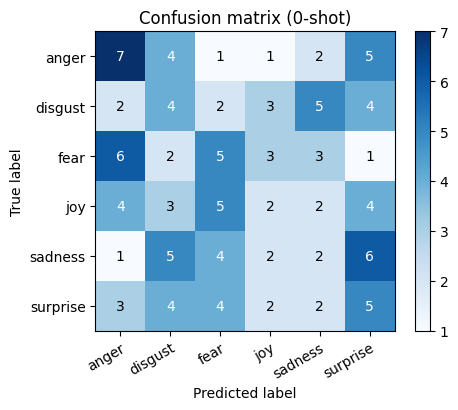

LLM classifying [surprise]: 100%|██████████| 20/20 [30:00<00:00, 90.01s/it]

[Saved] ./results/llm_classification_results\results_samples_20_shots_1.csv
Accuracy: 14.17%
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        20
     disgust       0.10      0.10      0.10        20
        fear       0.24      0.20      0.22        20
         joy       0.06      0.05      0.05        20
     sadness       0.20      0.25      0.22        20
    surprise       0.25      0.25      0.25        20

    accuracy                           0.14       120
   macro avg       0.14      0.14      0.14       120
weighted avg       0.14      0.14      0.14       120



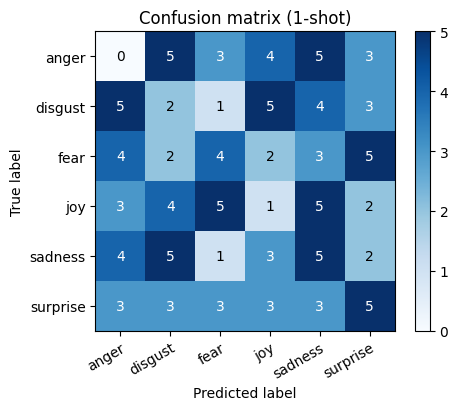

LLM classifying [surprise]: 100%|██████████| 20/20 [30:00<00:00, 90.00s/it]

[Saved] ./results/llm_classification_results\results_samples_20_shots_5.csv
Accuracy: 18.33%
              precision    recall  f1-score   support

       anger       0.21      0.30      0.25        20
     disgust       0.12      0.15      0.14        20
        fear       0.22      0.10      0.14        20
         joy       0.25      0.30      0.27        20
     sadness       0.18      0.15      0.16        20
    surprise       0.11      0.10      0.11        20

    accuracy                           0.18       120
   macro avg       0.18      0.18      0.18       120
weighted avg       0.18      0.18      0.18       120



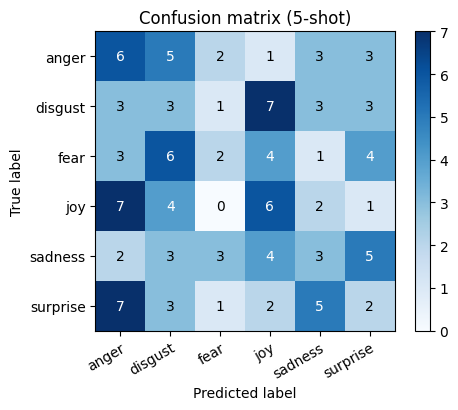

In [ ]:
# 0-shot
_ = run_experiment(train_df, train_df, num_test_samples=20, num_shots=0)

# 1-shot
_ = run_experiment(train_df, train_df, num_test_samples=20, num_shots=1)

# 5-shot
_ = run_experiment(train_df, train_df, num_test_samples=20, num_shots=5)


## Confusion Matrix 趨勢分析
- 主要改善點
    - 對角線（代表分類正確）整體在 5-shot 下比 0-shot/1-shot 更高。

- 最明顯改善的類別
    - joy（快樂）：5-shot 時有大量正確分類。
    - disgust（噁心）：5-shot 時辨識到 7。
    - anger（憤怒）：0-shot/5-shot 都有 6–7，代表 baseline 就很好，5-shot 更穩定。

- 仍然容易混淆的幾類
    - fear（害怕） 和 surprise（驚訝） 有交互誤判（害怕容易被判成驚訝）。
    - joy（快樂）、sadness（難過） 在 1-shot 中特別混亂。
    - sadness（難過） 本身在三種設定中都很分散，表示模型對中性詞彙不太敏感。

#### **三者差異**
| 模式         | 效果   | 特徵                                 |
| ---------- | ---- | ---------------------------------- |
| **0-shot** | 中等   | 靠模型本身語意理解，某些類別辨識好（anger/fear），但易混淆 |
| **1-shot** | 最不穩定 | 容易被示例誤導，導致過度擬合                     |
| **5-shot** | 最佳   | 情緒分類明顯有改善，對角線最集中                    |
